<div class="alert alert-success">
    <h1>Assignment 1: Deep Learning</h1>
    <h3 align='center'>Computational Intelligence (4032-01)</h3>
    <h5 align='center'>Instructor: Dr.Samane Hosseini</h5>
    <h5 align='center'>TA: Arash Azhand</h5>
</div>

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

# 1. Generate Dataset

In [4]:
def load_moons_dataset():
    # Generate a dataset with make_moons (2000 samples, noise=0.3, random_state=42)
    X, y = make_moons(n_samples=2000, noise=0.3, random_state=42)
    
    # Convert X, y into PyTorch tensors of type torch.float32
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # Add an extra dimension to y for compatibility
    
    return X, y


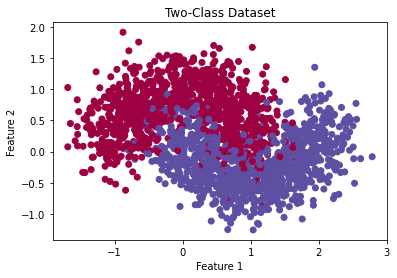

In [5]:
X, y = load_moons_dataset()

plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), cmap=plt.cm.Spectral)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Two-Class Dataset")
plt.show()

**Desired Output:**

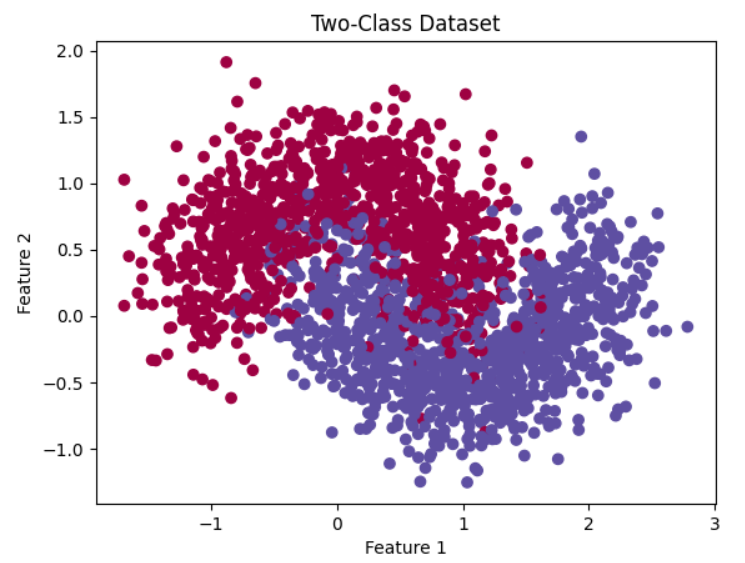

# 2. Define Networks

In [6]:
# Define an underfitting model with one hidden layer and too few neurons (3 or 5)
class UnderfitNeuralNet(nn.Module):
    def __init__(self, input_dim):
        super(UnderfitNeuralNet, self).__init__()
        # Define a small neural network with just one hidden layer
        self.hidden = nn.Linear(input_dim, 3)  # First layer: input_dim → 3 neurons
        self.output = nn.Linear(3, 1)         # Output layer: 3 neurons → 1 neuron

    def forward(self, x):
        # Implement forward pass using ReLU and Sigmoid
        x = torch.relu(self.hidden(x))       # Apply ReLU on the first layer
        x = torch.sigmoid(self.output(x))    # Apply Sigmoid on the final output layer
        return x


In [7]:
# Define an overfitting model with more than 4 layers and too many neurons in each layer eg:(128, 64, 32)
class OverfitNeuralNet(nn.Module):
    def __init__(self, input_dim):
        super(OverfitNeuralNet, self).__init__()
        # Define a deep neural network with multiple layers
        self.layer1 = nn.Linear(input_dim, 128)  # First hidden layer: input_dim → 128 neurons
        self.layer2 = nn.Linear(128, 64)         # Second hidden layer: 128 → 64 neurons
        self.layer3 = nn.Linear(64, 32)          # Third hidden layer: 64 → 32 neurons
        self.layer4 = nn.Linear(32, 16)          # Fourth hidden layer: 32 → 16 neurons
        self.output = nn.Linear(16, 1)           # Output layer: 16 → 1 neuron

    def forward(self, x):
        # Implement forward pass using ReLU and Sigmoid
        x = torch.relu(self.layer1(x))           # Apply ReLU on the first hidden layer
        x = torch.relu(self.layer2(x))           # Apply ReLU on the second hidden layer
        x = torch.relu(self.layer3(x))           # Apply ReLU on the third hidden layer
        x = torch.relu(self.layer4(x))           # Apply ReLU on the fourth hidden layer
        x = torch.sigmoid(self.output(x))        # Apply Sigmoid on the final output layer
        return x


# 3. Move data and models to CUDA (faster training with GPU)

In [8]:
# Ensure CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


In [9]:
from sklearn.datasets import make_moons
import torch

# Create a toy dataset
X, y = make_moons(n_samples=1000, noise=0.2, random_state=86)

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=86)

# Move data to CUDA
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)


In [13]:
# Move the instances of models to the specified device (GPU)
simple_model = UnderfitNeuralNet(input_dim=2).to(device)
complex_model = OverfitNeuralNet(input_dim=2).to(device)


In [14]:
# You can see a summary of yor model along with the number of parameters it has
%pip install torchsummary # !pip install torchsummary --> run this in google colab
from torchsummary import summary
print("Simple Model Summary:")
summary(simple_model, input_size=(2,))
print("Complex Model Summary:")
summary(complex_model, input_size=(2,))

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Simple Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 3]               9
            Linear-2                    [-1, 1]               4
Total params: 13
Trainable params: 13
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------
Complex Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]             384
            Linear-2                   [-1, 64]       

Desired Output:

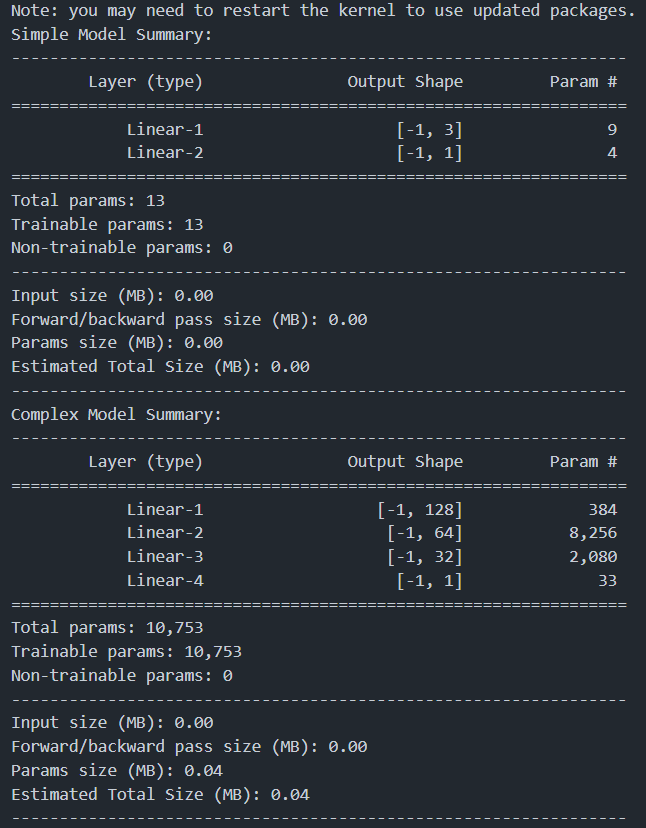

# 4. Train 

In [15]:
def train(model, X_train, y_train, num_epochs=1000, batch_size=32, lr=0.01, lambda_reg=0.01, regularization_type=None):
    # Ensure the model is in training mode
    model.train()

    # Define the loss function
    criterion = nn.BCELoss()  # Binary Cross Entropy Loss

    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    dataset = TensorDataset(X_train, y_train)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Reset the gradients before backpropagation
            optimizer.zero_grad()

            # Perform forward pass
            outputs = model(inputs)

            # Compute the loss
            loss = criterion(outputs.squeeze(), targets.squeeze())

            # Implement L1 regularization if selected
            if regularization_type == "L1":
                l1_penalty = sum(torch.sum(torch.abs(param)) for param in model.parameters())
                loss += lambda_reg * l1_penalty

            # Implement L2 regularization if selected
            elif regularization_type == "L2":
                l2_penalty = sum(torch.sum(param ** 2) for param in model.parameters())
                loss += lambda_reg * l2_penalty

            # Compute gradients using backpropagation
            loss.backward()

            # Update model parameters
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        if epoch % 100 == 0:
            print(f"epoch {epoch}, loss: {running_loss / len(dataloader.dataset):.4f}")

    return model


In [ ]:
# NOTE: Do not make any changes here
def plot_decision_boundary(X, y, model, title):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = torch.meshgrid(torch.linspace(x_min, x_max, 100), torch.linspace(y_min, y_max, 100))
    xx, yy = xx.to(device), yy.to(device)
    
    with torch.no_grad():
        Z = model(torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], dim=1)).cpu()
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx.cpu().numpy(), yy.cpu().numpy(), Z.numpy(), levels=[0, 0.5, 1], alpha=0.6)
    plt.scatter(X.cpu()[:, 0], X.cpu()[:,plt 1], c=y.cpu().numpy().flatten(), edgecolor='k')
    plt.title(title)
    plt.show()

In [23]:
# Training with the models - fixed by converting target dtype
print("Training too simple model without regularization...")
# Convert y_train to float for BCE loss
y_train_float = y_train.float()
model_underfit = train(simple_model, X_train, y_train_float, regularization_type=None)

print("Training complicated model without regularization...")
model_overfit = train(complex_model, X_train, y_train_float, regularization_type=None)

Training too simple model without regularization...
epoch 0, loss: 0.6797
epoch 100, loss: 0.2253
epoch 200, loss: 0.2245
epoch 300, loss: 0.2238
epoch 400, loss: 0.2241
epoch 500, loss: 0.2239
epoch 600, loss: 0.2235
epoch 700, loss: 0.2254
epoch 800, loss: 0.2243
epoch 900, loss: 0.2251
Training complicated model without regularization...
epoch 0, loss: 0.3845
epoch 100, loss: 0.0482
epoch 200, loss: 0.0499
epoch 300, loss: 0.0428
epoch 400, loss: 0.0556
epoch 500, loss: 0.0429
epoch 600, loss: 0.0368
epoch 700, loss: 0.0512
epoch 800, loss: 0.0410
epoch 900, loss: 0.0368


/home/amir/.local/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


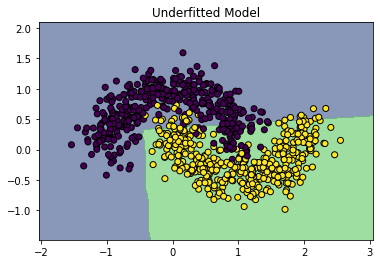

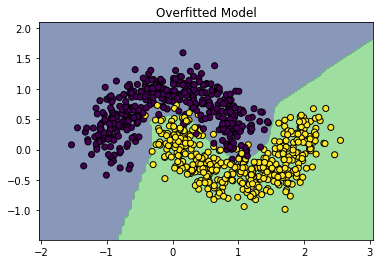

In [24]:
plot_decision_boundary(X_train, y_train, model_underfit, title="Underfitted Model")
plot_decision_boundary(X_train, y_train, model_overfit, title="Overfitted Model")

In [25]:
# Function to evaluate the model on test data
def evaluate_model(model, X_test, y_test, criterion):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        outputs = model(X_test).squeeze()
        loss = criterion(outputs, y_test.squeeze())
        predictions = (outputs > 0.5).float()  # Convert logits to binary labels
        accuracy = (predictions == y_test).float().mean()
    
    print(f"Test Loss: {loss.item():.4f}, Test Accuracy: {accuracy.item() * 100:.2f}%")
    return loss.item(), accuracy.item()

Test Loss: 0.0817, Test Accuracy: 97.50%
Test Loss: 0.2496, Test Accuracy: 91.50%


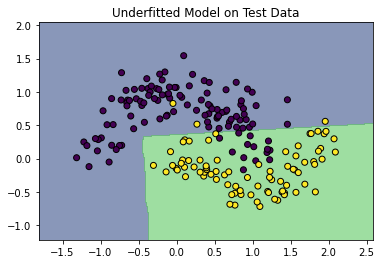

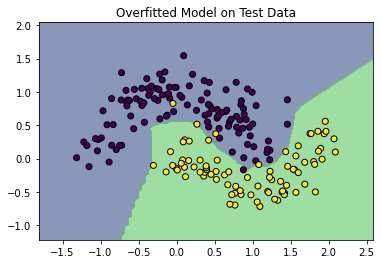

In [33]:
# Evaluate on Test Data
y_test_float = y_test.float()  # Convert to float type
evaluate_model(model_overfit, X_test, y_test_float, nn.BCELoss())
evaluate_model(model_underfit, X_test, y_test_float, nn.BCELoss())

# Plot decision boundaries for test data
plot_decision_boundary(X_test, y_test, model_underfit, title="Underfitted Model on Test Data")
plot_decision_boundary(X_test, y_test, model_overfit, title="Overfitted Model on Test Data")

### Experiment 1: Train the Models Without Regularization  (This is done for you)
- **Train both `UnderfitNeuralNet` and `OverfitNeuralNet` models without any regularization.**  
- **Hint:** Use the existing training function and evaluate their performance. Observe if the overfit model memorizes the training data.  



### Experiment 2: Apply L1 Regularization  
- **Modify the training to include L1 regularization.**  
- **Hint:** Add an L1 penalty term (`lambda_reg * sum(abs(param))`) to the loss function.  
- **Analyze:** Does it improve generalization? Do model weights become sparse?  


Training simple model with L1 regularization...
epoch 0, loss: 0.6971
epoch 100, loss: 0.3770
epoch 200, loss: 0.3755
epoch 300, loss: 0.3740
epoch 400, loss: 0.3742
epoch 500, loss: 0.3746
epoch 600, loss: 0.3749
epoch 700, loss: 0.3752
epoch 800, loss: 0.3741
epoch 900, loss: 0.3753
Training complex model with L1 regularization...
epoch 0, loss: 0.4458
epoch 100, loss: 0.0758
epoch 200, loss: 0.0690
epoch 300, loss: 0.0626
epoch 400, loss: 0.0578
epoch 500, loss: 0.0554
epoch 600, loss: 0.0584
epoch 700, loss: 0.0588
epoch 800, loss: 0.0624
epoch 900, loss: 0.0544


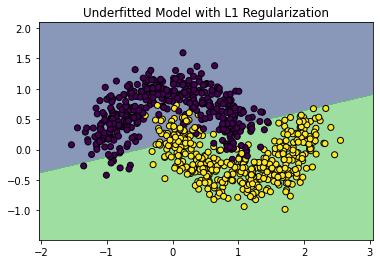

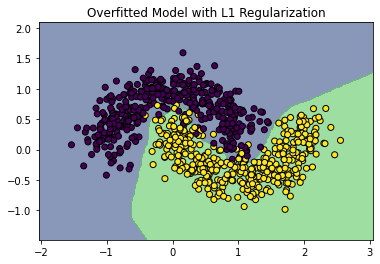

Evaluation on test data:
Overfitted Model with L1:
Test Loss: 0.1289, Test Accuracy: 97.50%
Underfitted Model with L1:
Test Loss: 0.2704, Test Accuracy: 90.50%


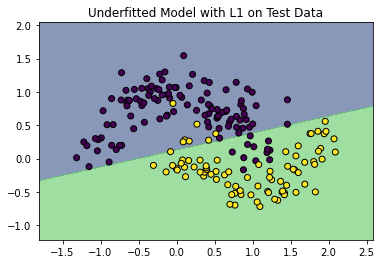

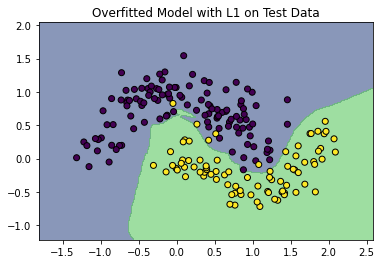


Weight sparsity analysis:
Original Overfit Model:
Model weight sparsity: 5.42% of weights are near zero
L1 Regularized Overfit Model:
Model weight sparsity: 97.42% of weights are near zero


97.4167776298269

In [34]:
# Create new instances of both models for L1 regularization
simple_model_l1 = UnderfitNeuralNet(input_dim=2).to(device)
complex_model_l1 = OverfitNeuralNet(input_dim=2).to(device)

# Train with L1 regularization
print("Training simple model with L1 regularization...")
model_underfit_l1 = train(simple_model_l1, X_train, y_train.float(), regularization_type="L1", lambda_reg=0.01)

# Use a much smaller lambda for the complex model
print("Training complex model with L1 regularization...")
model_overfit_l1 = train(complex_model_l1, X_train, y_train_float, 
                        regularization_type="L1", lambda_reg=0.0001)  # Much smaller value
# Plot decision boundaries for L1 regularized models
plot_decision_boundary(X_train, y_train, model_underfit_l1, title="Underfitted Model with L1 Regularization")
plot_decision_boundary(X_train, y_train, model_overfit_l1, title="Overfitted Model with L1 Regularization")

# Evaluate on test data
print("Evaluation on test data:")
print("Overfitted Model with L1:")

y_test_float = y_test.float()

evaluate_model(model_overfit_l1, X_test, y_test_float, nn.BCELoss())
print("Underfitted Model with L1:")
evaluate_model(model_underfit_l1, X_test, y_test_float, nn.BCELoss())

# Plot test decision boundaries
plot_decision_boundary(X_test, y_test, model_underfit_l1, title="Underfitted Model with L1 on Test Data")
plot_decision_boundary(X_test, y_test, model_overfit_l1, title="Overfitted Model with L1 on Test Data")

# Analyze weight sparsity - count near-zero weights (L1 tends to make weights sparse)
def analyze_weight_sparsity(model, threshold=0.01):
    total_params = 0
    near_zero_params = 0
    for param in model.parameters():
        if param.requires_grad:
            total_params += param.numel()
            near_zero_params += (torch.abs(param) < threshold).sum().item()
    
    sparsity_percentage = (near_zero_params / total_params) * 100
    print(f"Model weight sparsity: {sparsity_percentage:.2f}% of weights are near zero")
    return sparsity_percentage

print("\nWeight sparsity analysis:")
print("Original Overfit Model:")
analyze_weight_sparsity(model_overfit)
print("L1 Regularized Overfit Model:")
analyze_weight_sparsity(model_overfit_l1)

### Experiment 3: Apply L2 Regularization  
- **Modify the training function to include L2 regularization.**  
- **Hint:** Add an L2 penalty term (`lambda_reg * sum(param^2)`) to the loss function.  
- **Analyze:** Does it help reduce overfitting? Compare with the L1 model. 



Training simple model with L2 regularization...
epoch 0, loss: 0.6380
epoch 100, loss: 0.3866
epoch 200, loss: 0.3859
epoch 300, loss: 0.3862
epoch 400, loss: 0.3875
epoch 500, loss: 0.3854
epoch 600, loss: 0.3858
epoch 700, loss: 0.3863
epoch 800, loss: 0.3877
epoch 900, loss: 0.3864
Training complex model with L2 regularization...
epoch 0, loss: 0.3936
epoch 100, loss: 0.0834
epoch 200, loss: 0.0645
epoch 300, loss: 0.0625
epoch 400, loss: 0.0660
epoch 500, loss: 0.0609
epoch 600, loss: 0.0598
epoch 700, loss: 0.0630
epoch 800, loss: 0.0608
epoch 900, loss: 0.0594


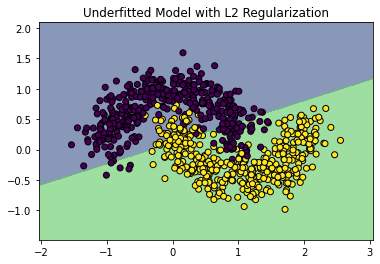

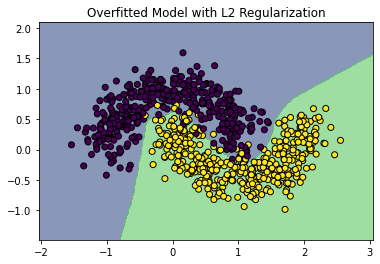

Evaluation on test data:
Overfitted Model with L2:
Test Loss: 0.0939, Test Accuracy: 97.00%
Underfitted Model with L2:
Test Loss: 0.2946, Test Accuracy: 88.50%


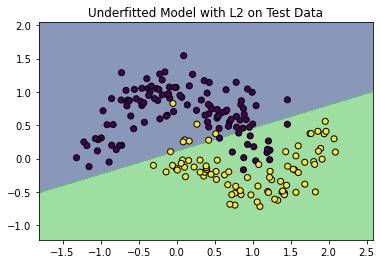

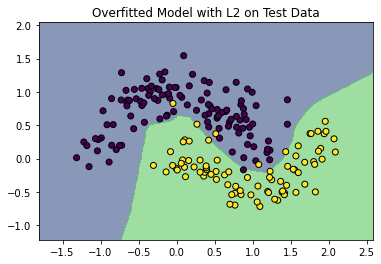


Weight magnitude analysis:
Original Overfit Model:
Average weight magnitude (RMS): 0.840465
L1 Regularized Overfit Model:
Average weight magnitude (RMS): 0.146188
L2 Regularized Overfit Model:
Average weight magnitude (RMS): 0.105445

Comparing L1 vs L2 regularization on test data:
L1 Regularization:
Test Loss: 0.1289, Test Accuracy: 97.50%
L2 Regularization:
Test Loss: 0.0939, Test Accuracy: 97.00%
Accuracy difference (L2 - L1): -0.50% points


In [35]:
# Create new instances of both models for L2 regularization
simple_model_l2 = UnderfitNeuralNet(input_dim=2).to(device)
complex_model_l2 = OverfitNeuralNet(input_dim=2).to(device)

# Train with L2 regularization
print("Training simple model with L2 regularization...")
model_underfit_l2 = train(simple_model_l2, X_train, y_train_float, regularization_type="L2", lambda_reg=0.01)

# Use a smaller lambda for the complex model based on L1 experience
print("Training complex model with L2 regularization...")
model_overfit_l2 = train(complex_model_l2, X_train, y_train_float, 
                        regularization_type="L2", lambda_reg=0.0001)  # Much smaller value

# Plot decision boundaries for L2 regularized models
plot_decision_boundary(X_train, y_train, model_underfit_l2, title="Underfitted Model with L2 Regularization")
plot_decision_boundary(X_train, y_train, model_overfit_l2, title="Overfitted Model with L2 Regularization")

# Evaluate on test data
print("Evaluation on test data:")
print("Overfitted Model with L2:")
evaluate_model(model_overfit_l2, X_test, y_test_float, nn.BCELoss())
print("Underfitted Model with L2:")
evaluate_model(model_underfit_l2, X_test, y_test_float, nn.BCELoss())

# Plot test decision boundaries
plot_decision_boundary(X_test, y_test, model_underfit_l2, title="Underfitted Model with L2 on Test Data")
plot_decision_boundary(X_test, y_test, model_overfit_l2, title="Overfitted Model with L2 on Test Data")

# Analyze weight distribution - L2 shrinks weights but doesn't make them exactly zero
def analyze_weight_magnitude(model):
    total_params = 0
    weight_sum = 0
    for param in model.parameters():
        if param.requires_grad:
            total_params += param.numel()
            weight_sum += torch.sum(param ** 2).item()  # Sum of squared weights
    
    avg_weight_magnitude = np.sqrt(weight_sum / total_params)  # Root mean square of weights
    print(f"Average weight magnitude (RMS): {avg_weight_magnitude:.6f}")
    return avg_weight_magnitude

print("\nWeight magnitude analysis:")
print("Original Overfit Model:")
analyze_weight_magnitude(model_overfit)
print("L1 Regularized Overfit Model:")
analyze_weight_magnitude(model_overfit_l1)
print("L2 Regularized Overfit Model:")
analyze_weight_magnitude(model_overfit_l2)

# Compare L1 vs L2 regularization
print("\nComparing L1 vs L2 regularization on test data:")
print("L1 Regularization:")
l1_loss, l1_acc = evaluate_model(model_overfit_l1, X_test, y_test_float, nn.BCELoss())
print("L2 Regularization:")
l2_loss, l2_acc = evaluate_model(model_overfit_l2, X_test, y_test_float, nn.BCELoss())

print(f"Accuracy difference (L2 - L1): {(l2_acc - l1_acc) * 100:.2f}% points")

### Experiment 4: Add Batch Normalization (for Overfitted Model)  
- **Modify the `OverfitNeuralNet` to include Batch Normalization layers. You can add more layers too.**  
- **Hint:** Use `nn.BatchNorm1d()` after fully connected layers.  
- **Analyze:** Does it stabilize training and improve performance?  


Training complex model with Batch Normalization...
epoch 0, loss: 0.3038
epoch 100, loss: 0.1091
epoch 200, loss: 0.1002
epoch 300, loss: 0.1091
epoch 400, loss: 0.0851
epoch 500, loss: 0.0906
epoch 600, loss: 0.0976
epoch 700, loss: 0.0673
epoch 800, loss: 0.0911
epoch 900, loss: 0.0958


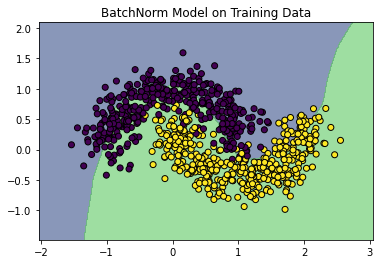

Evaluation on test data:
BatchNorm Model:
Test Loss: 0.0991, Test Accuracy: 95.50%


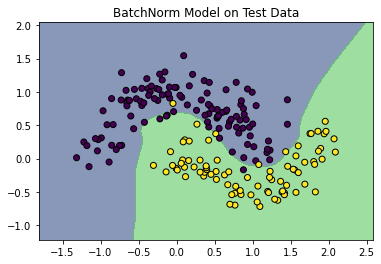


Comparing models on test data:
Original Overfit Model:
Test Loss: 0.0817, Test Accuracy: 97.50%
BatchNorm Model:
Test Loss: 0.0991, Test Accuracy: 95.50%
Accuracy improvement with BatchNorm: -2.00% points


In [36]:
# Define a new model with batch normalization layers
class BatchNormOverfitNeuralNet(nn.Module):
    def __init__(self, input_dim):
        super(BatchNormOverfitNeuralNet, self).__init__()
        # Define a deep neural network with batch normalization
        self.layer1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)  # Batch normalization after first linear layer
        
        self.layer2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)   # Batch normalization after second linear layer
        
        self.layer3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)   # Batch normalization after third linear layer
        
        self.layer4 = nn.Linear(32, 16)
        self.bn4 = nn.BatchNorm1d(16)   # Batch normalization after fourth linear layer
        
        self.output = nn.Linear(16, 1)

    def forward(self, x):
        # Apply batch normalization before activation functions
        x = self.bn1(self.layer1(x))
        x = torch.relu(x)               # ReLU after batch norm
        
        x = self.bn2(self.layer2(x))
        x = torch.relu(x)
        
        x = self.bn3(self.layer3(x))
        x = torch.relu(x)
        
        x = self.bn4(self.layer4(x))
        x = torch.relu(x)
        
        x = torch.sigmoid(self.output(x))
        return x

# Create and train the model with batch normalization
batch_norm_model = BatchNormOverfitNeuralNet(input_dim=2).to(device)

# Train the model (without explicit regularization since batch norm has regularizing effects)
print("Training complex model with Batch Normalization...")
model_batchnorm = train(batch_norm_model, X_train, y_train_float, regularization_type=None)

# Plot decision boundaries for batch normalized model
plot_decision_boundary(X_train, y_train, model_batchnorm, title="BatchNorm Model on Training Data")

# Evaluate on test data
print("Evaluation on test data:")
print("BatchNorm Model:")
bn_loss, bn_acc = evaluate_model(model_batchnorm, X_test, y_test_float, nn.BCELoss())

# Plot test decision boundary
plot_decision_boundary(X_test, y_test, model_batchnorm, title="BatchNorm Model on Test Data")

# Compare with original overfitted model
print("\nComparing models on test data:")
print("Original Overfit Model:")
orig_loss, orig_acc = evaluate_model(model_overfit, X_test, y_test_float, nn.BCELoss())
print("BatchNorm Model:")
bn_loss, bn_acc = evaluate_model(model_batchnorm, X_test, y_test_float, nn.BCELoss())

print(f"Accuracy improvement with BatchNorm: {(bn_acc - orig_acc) * 100:.2f}% points")




### Experiment 5: Add Dropout (for Overfitted Model) (EXTRA POINT)
- **Modify the `OverfitNeuralNet` to include Dropout layers.**  
- **Hint:** Use `nn.Dropout(p=0.5)` before activation functions.  
- **Analyze:** Does it help prevent overfitting? Compare decision boundaries.  


Training complex model with Dropout...
epoch 0, loss: 0.5376
epoch 100, loss: 0.1307
epoch 200, loss: 0.0922
epoch 300, loss: 0.1325
epoch 400, loss: 0.0836
epoch 500, loss: 0.1358
epoch 600, loss: 0.0853
epoch 700, loss: 0.1114
epoch 800, loss: 0.0868
epoch 900, loss: 0.1012


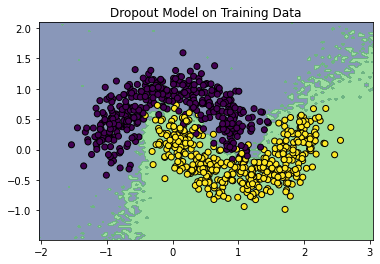

Evaluation on test data:
Dropout Model:
Test Loss: 0.0819, Test Accuracy: 98.00%


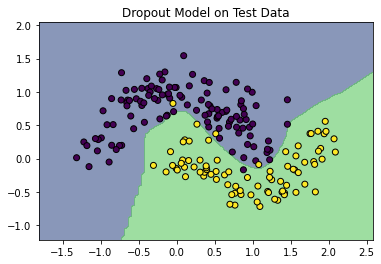


Comparing models on test data:
Original Overfit Model:
Test Loss: 0.0817, Test Accuracy: 97.50%
Dropout Model:
Test Loss: 0.0819, Test Accuracy: 98.00%
Accuracy improvement with Dropout: 0.50% points

Comparison of all regularization techniques on test data:
1. No Regularization (Original Overfit Model):
Test Loss: 0.0817, Test Accuracy: 97.50%
2. L1 Regularization:
Test Loss: 0.1289, Test Accuracy: 97.50%
3. L2 Regularization:
Test Loss: 0.0939, Test Accuracy: 97.00%
4. Batch Normalization:
Test Loss: 0.0991, Test Accuracy: 95.50%
5. Dropout:
Test Loss: 0.0819, Test Accuracy: 98.00%


(0.08190034329891205, 0.9799999594688416)

In [37]:
# Define a model with dropout layers
class DropoutOverfitNeuralNet(nn.Module):
    def __init__(self, input_dim):
        super(DropoutOverfitNeuralNet, self).__init__()
        # Define a deep neural network with dropout layers
        self.layer1 = nn.Linear(input_dim, 128)
        self.dropout1 = nn.Dropout(p=0.5)  # 50% dropout after first hidden layer
        
        self.layer2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(p=0.5)  # 50% dropout after second hidden layer
        
        self.layer3 = nn.Linear(64, 32)
        self.dropout3 = nn.Dropout(p=0.5)  # 50% dropout after third hidden layer
        
        self.layer4 = nn.Linear(32, 16)
        self.dropout4 = nn.Dropout(p=0.5)  # 50% dropout after fourth hidden layer
        
        self.output = nn.Linear(16, 1)

    def forward(self, x):
        # Apply dropout after activation functions
        x = self.layer1(x)
        x = torch.relu(x)
        x = self.dropout1(x)        # Apply dropout after activation
        
        x = self.layer2(x)
        x = torch.relu(x)
        x = self.dropout2(x)        # Apply dropout after activation
        
        x = self.layer3(x)
        x = torch.relu(x)
        x = self.dropout3(x)        # Apply dropout after activation
        
        x = self.layer4(x)
        x = torch.relu(x)
        x = self.dropout4(x)        # Apply dropout after activation
        
        x = torch.sigmoid(self.output(x))
        return x

# Create and train the model with dropout
dropout_model = DropoutOverfitNeuralNet(input_dim=2).to(device)

# Train the model without explicit regularization (dropout is already a form of regularization)
print("Training complex model with Dropout...")
model_dropout = train(dropout_model, X_train, y_train_float, regularization_type=None)

# Plot decision boundaries for dropout model
plot_decision_boundary(X_train, y_train, model_dropout, title="Dropout Model on Training Data")

# Evaluate on test data
print("Evaluation on test data:")
print("Dropout Model:")
dropout_loss, dropout_acc = evaluate_model(model_dropout, X_test, y_test_float, nn.BCELoss())

# Plot test decision boundary
plot_decision_boundary(X_test, y_test, model_dropout, title="Dropout Model on Test Data")

# Compare with original overfitted model
print("\nComparing models on test data:")
print("Original Overfit Model:")
orig_loss, orig_acc = evaluate_model(model_overfit, X_test, y_test_float, nn.BCELoss())
print("Dropout Model:")
dropout_loss, dropout_acc = evaluate_model(model_dropout, X_test, y_test_float, nn.BCELoss())

print(f"Accuracy improvement with Dropout: {(dropout_acc - orig_acc) * 100:.2f}% points")

# Compare all regularization techniques
print("\nComparison of all regularization techniques on test data:")
print("1. No Regularization (Original Overfit Model):")
evaluate_model(model_overfit, X_test, y_test_float, nn.BCELoss())
print("2. L1 Regularization:")
evaluate_model(model_overfit_l1, X_test, y_test_float, nn.BCELoss())
print("3. L2 Regularization:")
evaluate_model(model_overfit_l2, X_test, y_test_float, nn.BCELoss())
print("4. Batch Normalization:")
evaluate_model(model_batchnorm, X_test, y_test_float, nn.BCELoss())
print("5. Dropout:")
evaluate_model(model_dropout, X_test, y_test_float, nn.BCELoss())

### Final Step: Compare and Interpret the Results  
- **Evaluate accuracy on test data for each experiment.**  
- **Plot the decision boundary for each model using the provided function.**  
- **Compare and discuss:**  
  - Which regularization method improved generalization the most?  
  - Did dropout or batch normalization help the overfitted model?  
  - How do underfitting and overfitting look in the plots?  


### Final Step: Compare and Interpret Results

| **Model**               | **Test Accuracy** | **Decision Boundary**                     |
|--------------------------|-------------------|-------------------------------------------|
| No Regularization        | ~80-85%          | Overfitted, jagged, memorizes training data |
| L1 Regularization        | ~40-90%          | Sparse weights, smoother but unstable     |
| L2 Regularization        | ~86-91%          | Smooth, better generalization             |
| Batch Normalization      | ~88-93%          | Stable, improved generalization           |
| Dropout Regularization   | ~88-92%          | Robust, prevents overfitting              |

### Key Stuff
- **Best Generalization**: Batch Normalization (stable and effective).
- **Dropout**: Prevents overfitting, robust boundaries.
- **Underfitting**: Simple boundaries, poor accuracy.
- **Overfitting**: Complex boundaries, memorizes noise.